# LightGBM demo

We will try to use LightGBM to setup a simple model to predict sales revenues.

## Initialization

In this section, we will bootstrap the notebook env with necessary packages, configs and predefined functions.

In [78]:
### Import libs

%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#setting figure size
from matplotlib.pyplot import rcParams
rcParams['figure.figsize'] = 10,5

# TIME SERIES
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.stattools import adfuller, acf, pacf,arma_order_select_ic
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs


# settings
import warnings
warnings.filterwarnings("ignore")


from sklearn import preprocessing

import lightgbm as lgb
from lightgbm import plot_importance, plot_tree
    
from decouple import config
import json

plt.style.use(config('plot_style'))

In [79]:
### Basic settings

# 2019-07-10 00:00:00 to 2019-10-09 23:59:59

DATETIME_START_OF_TRAIN = config('DATETIME_START_OF_TRAIN')
DATETIME_END_OF_TRAIN = config('DATETIME_END_OF_TRAIN')
DATETIME_START_OF_TEST = config('DATETIME_START_OF_TEST')
DATETIME_END_OF_TEST = config('DATETIME_END_OF_TEST')
DATETIME_START_OF_PREDICT = config('DATETIME_START_OF_PREDICT')
DATETIME_END_OF_PREDICT = config('DATETIME_END_OF_PREDICT')

# we use 1 day frequency for the time series
freq = config('freq')

# we predict for 7 days
prediction_length = config('prediction_length', cast=int)

# we also use 14 days as context length, this is the number of state updates accomplished before making predictions
context_length = config('context_length', cast=int)

sample_sites = config('sample_sites', cast=lambda v: [int(s.strip()) for s in v.split(',')])

## EDA

In this section, we will explore and try to find out the main characteristics of the data

In [111]:
### Predefined functions

# Stationarity tests
def test_stationarity(ts, prefix_title=prefix_title):
    
    #Perform Dickey-Fuller test:
    print('=' * 50)
    print(f"{prefix_title} Results of Dickey-Fuller Test")
    print('-' * 50)
    dftest = adfuller(ts, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)


# model = additive, multiplicative
def plot_stationarity(ts, freq, model="multiplicative"):
    # multiplicative
    res = sm.tsa.seasonal_decompose(ts,freq=freq, model=model)
    #plt.figure(figsize=(16,12))
    fig = res.plot()
    axs = fig.axes
    axs[0].set_title(f"{prefix_title}, multiplicative")
    fig.show()
    
def ts_plot_acf_pacf(y, lags=None, figsize=(20, 4), style='bmh', title=''):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    #with plt.style.context(style):    
    fig = plt.figure(figsize=figsize)
    layout = (1, 2)
    acf_ax = plt.subplot2grid(layout, (0, 0))
    pacf_ax = plt.subplot2grid(layout, (0, 1))

    smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.1)
    smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.1)
    acf_ax.set_title(title + " acf")
    pacf_ax.set_title(title + " pacf")

    plt.tight_layout()
    
    return 

def tsplot(y, lags=None, figsize=(10, 8), style='bmh', title=''):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    #with plt.style.context(style):    
    fig = plt.figure(figsize=figsize)
    layout = (3, 2)
    ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
    acf_ax = plt.subplot2grid(layout, (1, 0))
    pacf_ax = plt.subplot2grid(layout, (1, 1))
    qq_ax = plt.subplot2grid(layout, (2, 0))
    pp_ax = plt.subplot2grid(layout, (2, 1))

    y.plot(ax=ts_ax)
    ts_ax.set_title(title)
    smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.1)
    smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.1)
    sm.qqplot(y, line='s', ax=qq_ax)
    qq_ax.set_title('QQ Plot')
    scs.probplot(y, sparams=(y.mean(), y.std()), plot=pp_ax)

    plt.tight_layout()
    
    return 

In [20]:
df_sales = pd.read_csv('data/timeseries_raw.csv', header=None, sep=',', parse_dates=[0])
df_sales.rename(columns={0:"date"}, inplace=True)
df_sales.set_index(['date'], inplace=True)

df_sales = df_sales[~df_sales.index.isnull()]

df_sales.head()

,1,2,3,4,5,6,7,8,9,10,...,1595,1596,1597,1598,1599,1600,1601,1602,1603,1604
date,,,,,,,,,,,,,,,,,,,,,
2019-07-10,14.0,630.7,2074.9,1305.5,3629.0,993.5,1119.5,915.1,1118.0,3123.7,...,1575.6,561.1,1024.2,1156.1,907.8,604.6,1793.7,3159.7,1972.5,617.5
2019-07-11,18.0,764.3,1057.9,596.8,1368.8,816.2,1303.8,642.2,1004.6,2832.2,...,1482.1,573.5,1446.8,1564.6,925.8,774.0,1553.0,2983.9,1337.3,490.5
2019-07-12,22.4,673.7,1278.2,1055.9,1436.6,1186.3,2160.9,936.2,735.9,3013.7,...,1290.2,625.8,1187.5,1417.7,1048.2,756.3,2257.3,3241.3,2014.8,743.0
2019-07-13,28.5,701.3,1975.9,905.2,1222.7,501.7,1363.5,1476.7,1173.3,1868.3,...,385.1,533.9,1104.4,1170.9,635.1,1159.0,2245.7,1940.7,2256.5,497.5
2019-07-14,25.0,737.5,1641.7,1122.0,1139.1,81.3,1159.0,832.7,1104.4,1356.0,...,309.0,601.7,1287.2,735.2,645.8,945.4,1457.2,1482.5,1930.7,816.0


In [21]:
df_weather = pd.read_csv('data/shenzhen_weather.csv', header=0, sep=',', parse_dates=[0])
df_weather.set_index(['date'], inplace=True)

df_weather

,high_temp,low_temp,is_sunshine,is_rain,is_cloudy
date,,,,,
2019-07-10,29,26,0.0,1.0,0.0
2019-07-11,30,27,0.0,0.0,1.0
2019-07-12,32,28,0.0,0.0,1.0
2019-07-13,31,28,0.0,0.0,1.0
2019-07-14,31,28,0.0,1.0,0.0
...,...,...,...,...,...
2019-09-26,30,24,0.0,0.0,1.0
2019-09-27,31,24,0.0,0.0,1.0
2019-09-28,32,24,0.0,0.0,1.0


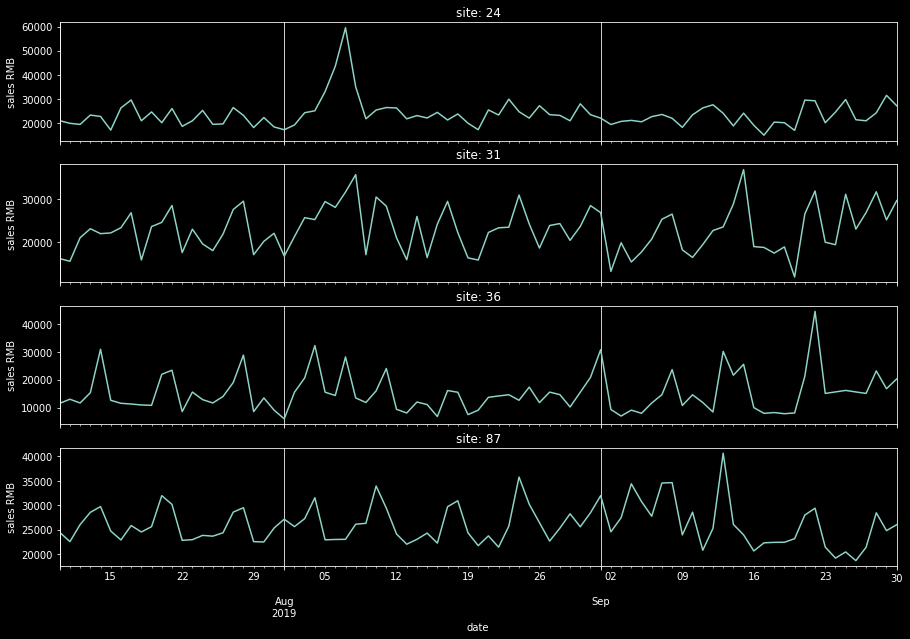

In [24]:
fig, axs = plt.subplots(len(sample_sites), 1, figsize=(15, 10), sharex=True)
axx = axs.ravel()
for i, site in enumerate(sample_sites):
    _ = df_sales.loc[:, site].plot(ax=axx[i], style='-', title=f"site: {site}")
    axx[i].set_xlabel("date")    
    axx[i].set_ylabel("sales RMB")   
    axx[i].grid(which='major', axis='x')

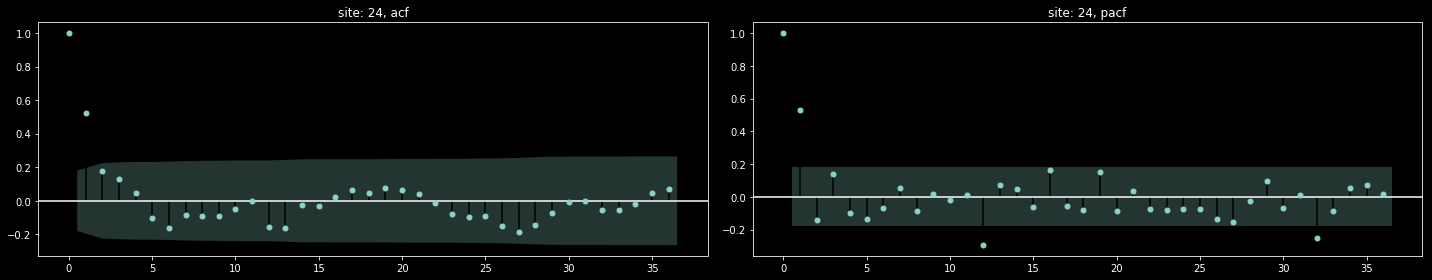

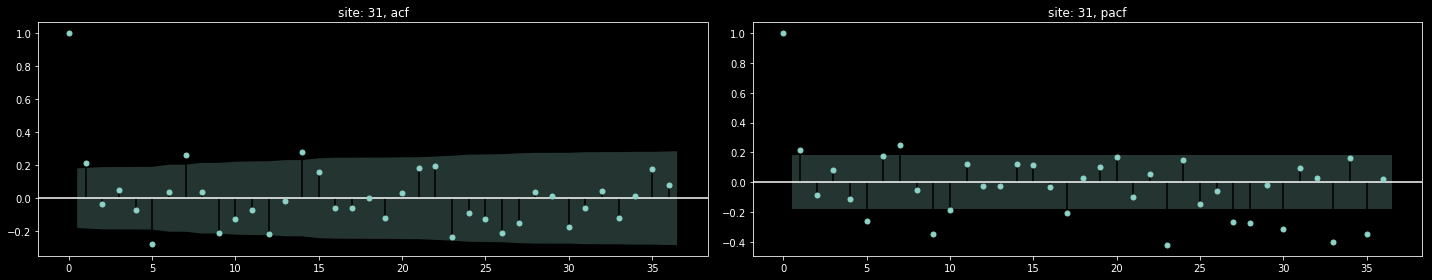

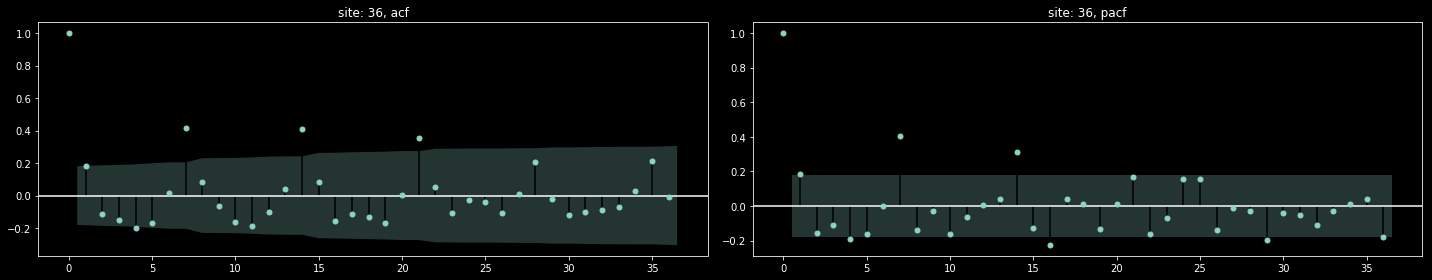

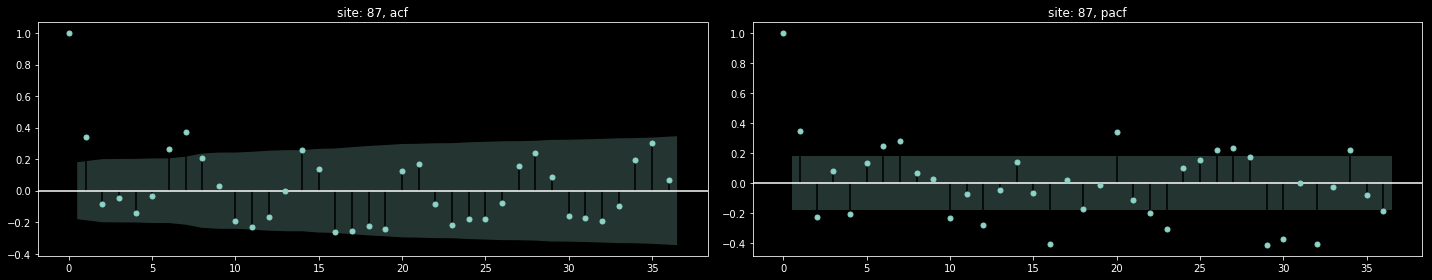

In [112]:
for i, site in enumerate(sample_sites):
    prefix_title = f"site: {site},"
    ts = df_sales.loc[:, site].values
    _ = ts_plot_acf_pacf(ts, lags=36,title=prefix_title)

In [98]:
lag_freq = 7

    
for i, site in enumerate(sample_sites):
    prefix_title = f"site_{site}: "

    ts = df.loc[:, site].values
    
    test_stationarity(ts, prefix_title=prefix_title)


site_24:  Results of Dickey-Fuller Test
--------------------------------------------------
Test Statistic                 -4.894663
p-value                         0.000036
#Lags Used                      1.000000
Number of Observations Used    81.000000
Critical Value (1%)            -3.513790
Critical Value (5%)            -2.897943
Critical Value (10%)           -2.586191
dtype: float64
site_31:  Results of Dickey-Fuller Test
--------------------------------------------------
Test Statistic                 -3.165510
p-value                         0.022070
#Lags Used                      8.000000
Number of Observations Used    74.000000
Critical Value (1%)            -3.521980
Critical Value (5%)            -2.901470
Critical Value (10%)           -2.588072
dtype: float64
site_36:  Results of Dickey-Fuller Test
--------------------------------------------------
Test Statistic                 -2.494485
p-value                         0.116822
#Lags Used                      6.000000


## Data Processing

In [84]:
### Predefined functions

def create_features(df, df_weather, label=None):
    """
    Creates time series features from datetime index
    """
    df['date'] = df.index
    #df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    #df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    #df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear
    
    X = df[['dayofweek', 'month',]]
    #X = df[['dayofyear','dayofmonth','weekofyear']]
    
    X = X.join(df_weather, how='left')

    if label:
        y = df[label]
        return X, y
    return X

In [85]:
df_train = df.loc[df.index <= DATETIME_START_OF_TEST, :].copy()
df_test = df.loc[(df.index >= DATETIME_START_OF_TEST) & (df.index <= DATETIME_START_OF_PREDICT), :].copy()

In [86]:
X_train, y_train = create_features(df_train, df_weather, label=sample_sites[3])
X_test, y_test = create_features(df_test, df_weather, label=sample_sites[3])

lgb_train = lgb.Dataset(X_train, y_train)
lgb_test = lgb.Dataset(X_test, y_test, reference=lgb_train)

## Training


In [87]:
### Configuration

params = {
    'num_leaves': 5,
    'metric': ['l1', 'l2'],
    'verbose': -1
}



In [88]:
### Fit Model

evals_result = {}  # to record eval results for plotting
gbm = lgb.train(params,
                lgb_train,
                num_boost_round=400,
                valid_sets=[lgb_train, lgb_test],
                #feature_name=['f' + str(i + 1) for i in range(X_train.shape[-1])],
                #categorical_feature=["dayofweek"],
                evals_result=evals_result,
                verbose_eval=10)

[10]	training's l1: 2300.58	training's l2: 1.02902e+07	valid_1's l1: 2844.16	valid_1's l2: 1.03107e+07
[20]	training's l1: 2099.72	training's l2: 9.30205e+06	valid_1's l1: 2727.99	valid_1's l2: 9.14022e+06
[30]	training's l1: 2034.58	training's l2: 9.04044e+06	valid_1's l1: 2865.93	valid_1's l2: 9.64968e+06
[40]	training's l1: 2001.1	training's l2: 8.95453e+06	valid_1's l1: 3011.99	valid_1's l2: 1.04193e+07
[50]	training's l1: 1991.38	training's l2: 8.91443e+06	valid_1's l1: 3061.15	valid_1's l2: 1.06733e+07
[60]	training's l1: 1986.41	training's l2: 8.88277e+06	valid_1's l1: 3061.02	valid_1's l2: 1.06268e+07
[70]	training's l1: 1981.84	training's l2: 8.85588e+06	valid_1's l1: 3070.17	valid_1's l2: 1.06411e+07
[80]	training's l1: 1975.38	training's l2: 8.83197e+06	valid_1's l1: 3093.7	valid_1's l2: 1.07488e+07
[90]	training's l1: 1971.53	training's l2: 8.80973e+06	valid_1's l1: 3115.37	valid_1's l2: 1.08492e+07
[100]	training's l1: 1967.87	training's l2: 8.789e+06	valid_1's l1: 3139.02

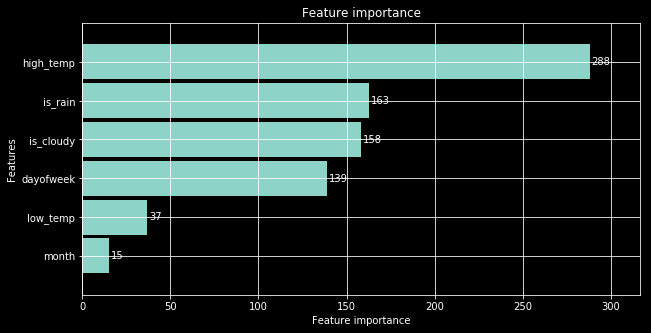

In [89]:
### Feature Importance
_ = plot_importance(gbm, height=0.9)

## Prediction

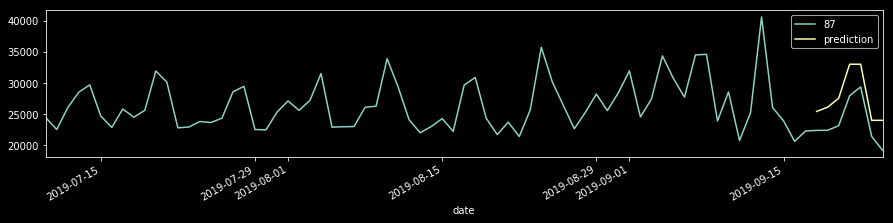

In [90]:
df_test['prediction'] = gbm.predict(X_test)
df_all = pd.concat([df_test, df_train], sort=False)
_ = df_all[[site,'prediction']].plot(figsize=(15, 3))

## Evaluate All Sites

[10]	training's l1: 3374.27	training's l2: 3.32815e+07	valid_1's l1: 4649.22	valid_1's l2: 2.58609e+07
[20]	training's l1: 3337.75	training's l2: 3.13423e+07	valid_1's l1: 4667.94	valid_1's l2: 2.68522e+07
[30]	training's l1: 3341.21	training's l2: 3.02616e+07	valid_1's l1: 4692.3	valid_1's l2: 2.78352e+07
[40]	training's l1: 3336.71	training's l2: 2.9524e+07	valid_1's l1: 4739.66	valid_1's l2: 2.85948e+07
[50]	training's l1: 3329.88	training's l2: 2.9008e+07	valid_1's l1: 4745.78	valid_1's l2: 2.90002e+07
[60]	training's l1: 3339.83	training's l2: 2.86464e+07	valid_1's l1: 4771.13	valid_1's l2: 2.97147e+07
[70]	training's l1: 3349.47	training's l2: 2.83755e+07	valid_1's l1: 4750.12	valid_1's l2: 2.98909e+07
[80]	training's l1: 3352.79	training's l2: 2.81952e+07	valid_1's l1: 4734.24	valid_1's l2: 2.99775e+07
[90]	training's l1: 3359.6	training's l2: 2.80458e+07	valid_1's l1: 4745.34	valid_1's l2: 2.99516e+07
[100]	training's l1: 3362.05	training's l2: 2.79238e+07	valid_1's l1: 4754.7	

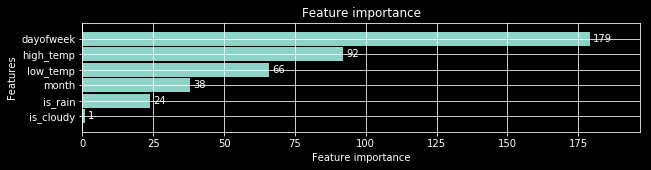

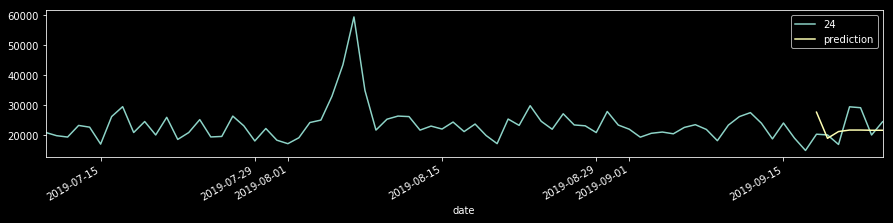

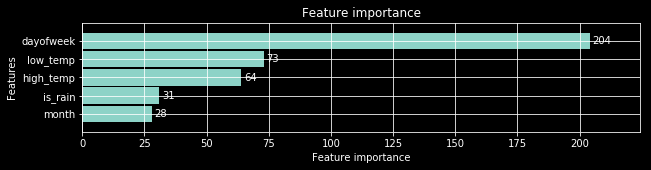

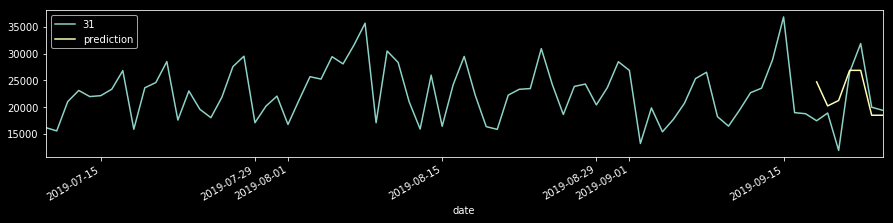

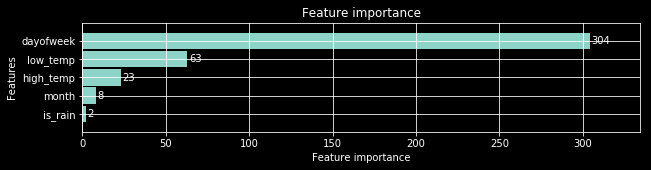

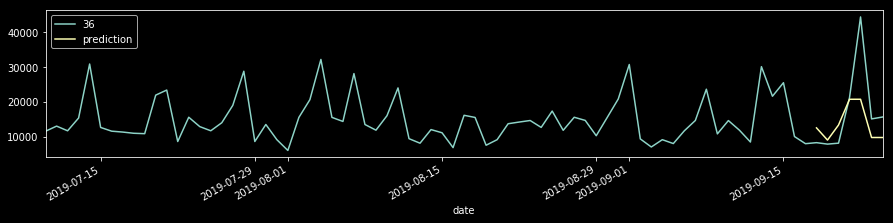

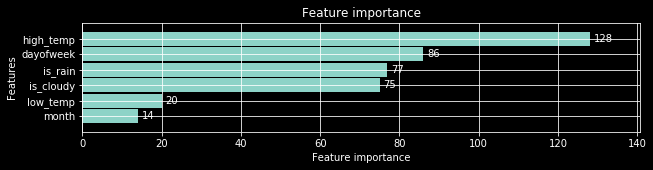

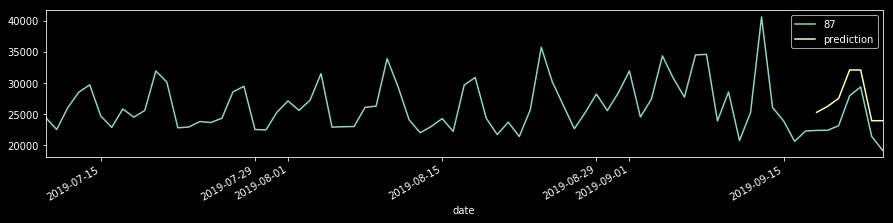

In [91]:
for i, site in enumerate(sample_sites):
    X_train, y_train = create_features(df_train, df_weather, label=site)
    X_test, y_test = create_features(df_test, df_weather, label=site)
    
    lgb_train = lgb.Dataset(X_train, y_train)
    lgb_test = lgb.Dataset(X_test, y_test, reference=lgb_train)
    
    evals_result = {}  # to record eval results for plotting
    gbm = lgb.train(params,
                    lgb_train,
                    num_boost_round=200,
                    valid_sets=[lgb_train, lgb_test],
                    #feature_name=['f' + str(i + 1) for i in range(X_train.shape[-1])],
                    #categorical_feature=["dayofweek"],
                    evals_result=evals_result,
                    verbose_eval=10)
    
    _ = plot_importance(gbm, height=0.9, figsize=(10, 2))
    
    df_test['prediction'] = gbm.predict(X_test)
    df_all = pd.concat([df_test, df_train], sort=False)
    _ = df_all[[site,'prediction']].plot(figsize=(15, 3))